# CS 3630 Project 3

## Outline

1. Markov Localization
2. Particle Filtering
3. Comparing the two algorithms
4. Path following using particle filtering
5. Submission

## Logistics

1. Date range: 2/15/2023 18:00 Wednesday - 3/3/2023 23:59 Friday.
2. Submission should be made to GradeScope. Please carefully read the submission guidelines.

## General Tips

1. Start early.
2. Make a copy of the notebook on Colab before running. (File > Save a copy in drive)
3. You will need to use the `numpy` library to complete the coding parts.
4. Check out the table of contents by clicking the top icon on the left bar.
5. **Read through every line of the notebook.**
6. For coding questions, fill in the code cells before you run them.
7. Have fun!

Created by Lixing and Maya. Cool arts credit to Maya. Spring 2022

Want to learn more about particle filtering? Check out this here escape room: https://sites.google.com/view/particlefilter3630/home
3

# Submission Guidelines

### **For Code**
In order to submit the file, once you complete the project:

1.   Click the “File” button on the toolbar at the top.
2.   Click “Download”.
3. And then click “Download .ipynb”.
4. You will now have the .ipynb file on your local machine.
5. Make sure it is named ***project3.ipynb***.
6. Submit the project3.ipynb file to Gradescope under "Project 3 - Code".



### **For Reflection Question**

You should also answer the reflection questions on Gradescope under **"Project 3 - Report"**.



# Set-Up: Make sure you run the following cells every time you restart Colab runtime


Install libraries which are necessary for this Notebook to run correctly. Feel free to check out each library.


1.  [GtBook](https://github.com/gtbook/gtbook) - Responsible for installing helper libraries like GTSAM and Plotly
2.  [Kaleido](https://github.com/plotly/Kaleido) - Helps in generating static images and plots
3.  [Ttictoc](https://github.com/hector-sab/ttictoc) - Helps measure the execution time for a block of code



In [ ]:
%pip install -q -U gtbook
%pip install -U kaleido
%pip install -U ttictoc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We import libraries which are used in the Notebook


1.   [NumPy](https://numpy.org/) - NumPy is an open source project aiming to enable numerical computing with Python.
2.   [Plotly](https://plotly.com/python/) - Plotly's Python graphing library makes interactive, publication-quality graphs
3.   [GTSAM](https://gtsam.org/) - GTSAM is a sensor fusion library based on factor graphs.
4.   [GtBook](https://github.com/gtbook/gtbook) - Responsible for installing helper libraries like GTSAM and Plotly
5.   [Ttictoc](https://github.com/hector-sab/ttictoc) - Helps measure the execution time for a block of code



In [ ]:
import numpy as np
from numpy.random import default_rng

rng = default_rng()

import plotly.express as px
import plotly.graph_objects as go
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook import logistics
from gtbook.display import show
from IPython.display import clear_output
from ttictoc import tic, toc


Here, we are seeding `np.random` to have uniformity while generating samples used later in the assignment:

In [ ]:
np.random.seed(0)

Firstly, we create a small ground truth trajectory. We generate this ground truth trajectory deterministically. 

We use the [gtsam.VectorValues](https://gtsam.org/doxygen/4.0.0/a03399.html) class to represent the trajectory; this will come in handy when we later simulate measurements.


In [ ]:
left = [(10 + i * 5, 6) for i in range(9)]
up = [(50, 6 + i * 5) for i in range(1, 6)]
N = len(left) + len(up)
indices = range(1, N + 1)
x = {k: gtsam.symbol('x', k) for k in indices}
values = gtsam.VectorValues()
for i, state in enumerate(left + up):
    values.insert(x[i + 1], state)
 # for each value of the variable, for instance (50, 26), the left number represents x coordinate, and the right number represents y coordinate
ground_truth = np.array([values.at(x[k]) for k in indices])
print("Ground truth trajectory index \t X Coordinate\tY Coordinate")
for index,i in enumerate(ground_truth):
  print("{} \t\t\t\t {}\t\t{}".format(index+1,i[0],i[1]))

Ground truth trajectory index 	 X Coordinate	Y Coordinate
1 				 10.0		6.0
2 				 15.0		6.0
3 				 20.0		6.0
4 				 25.0		6.0
5 				 30.0		6.0
6 				 35.0		6.0
7 				 40.0		6.0
8 				 45.0		6.0
9 				 50.0		6.0
10 				 50.0		11.0
11 				 50.0		16.0
12 				 50.0		21.0
13 				 50.0		26.0
14 				 50.0		31.0


Finally, we overlaying the ground truth trajectory on a map of the warehouse introduced in the [book](https://www.roboticsbook.org/S43_logistics_sensing.html)

In [ ]:
if __name__ == '__main__':
  logistics.show_map(logistics.base_map, ground_truth)

We start by initializing the finite element density representation with a prior, centered around the ground truth location, but with a relatively large standard deviation of 5 meter and then plot it

In [ ]:
if __name__ == '__main__':
  prior_mean = values.at(x[1])
  prior_cov = np.diag([25, 25])
  prior = logistics.gaussian(logistics.map_coords, prior_mean, prior_cov)
  logistics.show_map(prior / np.max(prior) + 0.1 * logistics.base_map)


We define a Utility function called `create_slide_show()` to show animation on warehouse map, possibly with markers and robots.

In [ ]:
from skimage import io
import os


def create_slide_show():
    img_list = []
    k = 1
    while True:
        if not os.path.exists("{}.png".format(k)):
            # print("Images not found! Please run simulation to collect images first.")
            break
        img = io.imread("{}.png".format(k))
        img_list.append(img)
        os.remove("{}.png".format(k))
        k += 1

    # If no images, don't do anything
    if len(img_list) == 0:
        return

    img_list = np.array(img_list)
    fig = px.imshow(img_list, animation_frame=0)
    fig.update_layout(showlegend=False)
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()

The utility function, `show_trajectory()`, shows the image of the warehouse map, with the possibly of adding markers and robots.

In [ ]:
def show_trajectory(gts, ests):
    fig = px.imshow(0.1 * logistics.base_map,
                    color_continuous_scale='Oranges',
                    origin="lower",
                    aspect='equal',
                    range_color=[0, 1])

    fig.add_scatter(x=gts[:, 0],
                    y=gts[:, 1],
                    mode="markers",
                    marker=dict(color="green", opacity=1, size=10))
    fig.add_scatter(x=ests[:, 0],
                    y=ests[:, 1],
                    mode="markers",
                    marker=dict(color="red", opacity=1, size=10))

    fig.update_layout(coloraxis_showscale=False,
                      margin=dict(l=0, r=0, t=0, b=0))
    fig.update_xaxes(range=[-0.5, 99.5], autorange=False)
    fig.update_yaxes(range=[-0.5, 49.5], autorange=False, scaleratio=1)
    fig.show()


# Part 1: Markov Localization [(Chapter 4.4.1 from the Book)](https://www.roboticsbook.org/S44_logistics_perception.html#markov-localization)


Meet Manuel, a robot that was born with the gift of Markov localization. Markov localization is an algorithm that uses a continuous state representation when performing localization task. Since the code of Markov Localization is already given to you in the textbook, we will focus on understanding the code and parameters that are used in Manuel's algorithm. For this section, you will tune Manuel's parameters and record the results in the online report on Gradescope.


![](https://drive.google.com/uc?export=view&id=1xbXUb59mSoPKmztWyIk4OUBccOeJMLK0)


_Art: Meet Manuel_


The hardest and most computationally demanding part in the Markov localization algorithm to implement is the prediction step. Recall the [formula](https://www.roboticsbook.org/S44_logistics_perception.html#warehouse-example):

>> $P(X_{k}|\mathcal{Z}^{k-1},\mathcal{U}^{k})=\sum_{x_{k-1}}P(X_{k}|x_{k-1},u_{k-1})P(x_{t-1}|\mathcal{Z}^{k-1},\mathcal{U}^{k-1})$


 
Hence, for every cell in the predictive density approximation, we need to sum over all cells in the previous image. 


We assume that the distribution of Manuel's possible locations after the motion is gaussian with a mean value at each location that could possibly be reached from Manuel's previous location and a covariance represented by the provided motion model sigma. Please read the code below to convince yourself that Manuel's motion is not deterministic, but indeed probabilistic: 

In [ ]:
def prediction_step(previous, control, motion_model_sigma):
    cov = np.eye(2) * motion_model_sigma**2

    H, W = 50, 100
    predictive_density = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            if previous[i, j] > 1e-5:
                previous_xy = logistics.map_coords[i, j]
                mean = previous_xy + control
                for k in range(H):
                    motion_model = logistics.gaussian(logistics.map_coords[k],
                                                      mean, cov)
                    predictive_density[k] += motion_model * previous[i, j]
    predictive_density = predictive_density / np.sum(predictive_density)
    return predictive_density

In fact, Manuel could be at any position with non-zero probability, so you will need to help Manuel perform a motion update at each possible location under the Markov continuous state model. **_This could be a problem if the number of states is huge._** And in the current assignment, there are 5000 (50 \* 100) cells in the grid map so there are 5000 states in total.


![](https://drive.google.com/uc?export=view&id=13PRNBJ2-Naac-MnyDwb-d4bpxDj3wJZC)


_Art: Where is Manuel?_


The following code is the main logic loop, or the "meat" of Markov Localization. In this example, Manuel wants to move between location values `k` and `k+1`. We get the current probability densities using the function above first with the motion model. We will correct the probability density by multiplying the likelihood given by our sensors; this will give us the posterior density. Below you will find the code for running Markov localization.


In [ ]:
def run_markov(prior,
               indices,
               control_values,
               motion_model_sigma,
               show_map=False):
    """
      Refer to the code in the text book for predictive density and posterior density calculation.
    """
    predictive_density = prior
    posterior_density = predictive_density * logistics.proximity_map_off
    posterior_density /= np.sum(posterior_density)
    posterior_density_sequence = [posterior_density]
    #Move from location 1->2->3->...
    for k in indices[:-1]:
        # prediction phase
        control = control_values.at(x[k + 1]) - control_values.at(
            x[k])  # ground truth control
        predictive_density = prediction_step(posterior_density, control,
                                             motion_model_sigma) 
        #Getting the current probability density
        posterior_density = predictive_density * logistics.proximity_map_off 
        #We multiply probility density with sensor likilehoods and get posterior density
        posterior_density /= np.sum(posterior_density)
        #Appending the answer to a list
        posterior_density_sequence.append(posterior_density)
        if show_map:
            logistics.show_map(posterior_density / np.max(posterior_density) +
                               0.1 * logistics.base_map,
                               file="{}.png".format(k))
            if k != indices[-2]:
                clear_output(wait=True)
    return posterior_density_sequence


### CODING TODO 1

The above code doesn't really show Manuel moving - it just returns all the possible Manuels in the warehouse. There is only _one_ Manuel we are concerned about. Therefore, we have to use these probabilities to estimate where the real Manuel is.

In the cell below: 
* Implement a function to figure out the estimated location from output posterior densities. 
* Use the weighted average of the locations based on the posterior densities. 

(Hint: use `np.average()` and you probably will need to flatten the posterior densities.)


In [ ]:
#Coding TODO 1
def get_markov_location_best_estimate(posterior_density):
    """
      posterior_density: 50 * 100 2d float array of posterior density
      
      Returns:
        best_estimate: (float, float), which is a coordinate (the weighted average of the positions)
    """
    positions = np.array([(j, i) for i in range(50) for j in range(100)])
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    posterior_density = np.ndarray.flatten(posterior_density)
    best_estimate = np.average(positions, axis=0, weights=posterior_density)
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
    return best_estimate

#### CODING TODO 2

In the next cell, calculate the average distance between the estimated locations and the ground truth, **and the averaged distance would be used as the error metric for the estimated locations in the assignment.** Low error value (shorter distance) means that the estimation is good.

* Loop over the ground truth values and calculate the accuracies using root mean square distance. 
* Save your estimates in the best_estimates array and return with the average distance. You are using the euclidean distance to calculate the distance between the estimated locations and the ground truth locations. 

You will need to call the function you implemented above (CODING TODO 1).

(Tip: use `np.linalg.norm`) 


In [ ]:
#Coding TODO 2
def get_markov_location_error(posterior_density_sequence, ground_truth_values):
    """
        Loop over the ground truth values and calculate the accuracies using root mean square distance.
        Save your estimates in the best_estimates array and return with the average distance.

        posterior_density_sequence: List[50 * 100 2d float array], list of posterior density for each step
        ground_truth_values: List[(flost, float)], list of ground truth locations for each step

        Returns:
          average_distance: float, average distance from the estimated locations to the ground truth
          best_estimates: List[(float, float)], list of location estimations along the trajectory 
            for each step with length equals to the ground_truth_values
    """
    
    n = len(ground_truth_values)
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    best_estimates = []
    distances = []
    for i in range(n):
      a = ground_truth_values[i]
      b = get_markov_location_best_estimate(posterior_density_sequence[i])
      dist = np.linalg.norm(a - b)
      best_estimates.append(b)
      distances.append(dist)
    average_distance = np.average(distances)
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
    # Return the average average_distance
    return best_estimates, average_distance

In the next cell, we use the functions we defined above to run markov localization and measure the time taken. We also compute the average error in Markov localization using the get get_markov_location_error defined by you in CODING TODO 2.

In [ ]:
if __name__ == '__main__':
  tic()

  motion_model_sigma = 1.0 # Change sigma here
  posterior_density_sequence = run_markov(prior, indices, values, motion_model_sigma, show_map=True)

  gts = np.array([values.at(x[k]) for k in indices])
  best_estimates, average_distance = get_markov_location_error(posterior_density_sequence, gts)
  print("Average error: ", average_distance)

  print(f"\nWall time: {toc()} s")

Average error:  1.3495920785875037

Wall time: 47.936393520999445 s


The following block is will create a slide show if the `show_map` was set to `True` in the previous block. 

**Comment this block before submitting to Gradescope.**


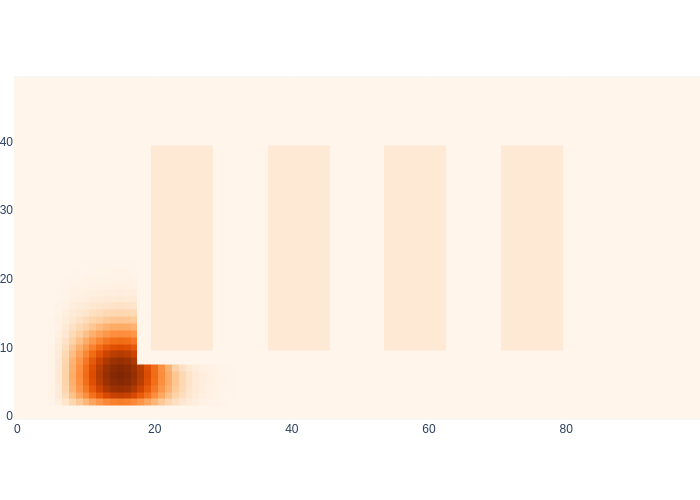
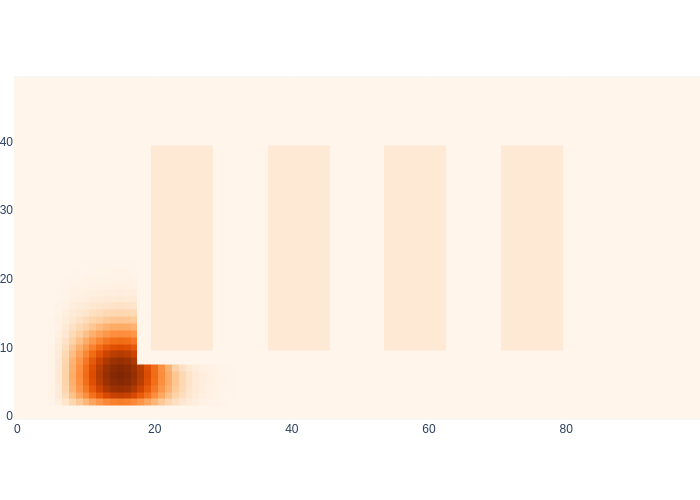
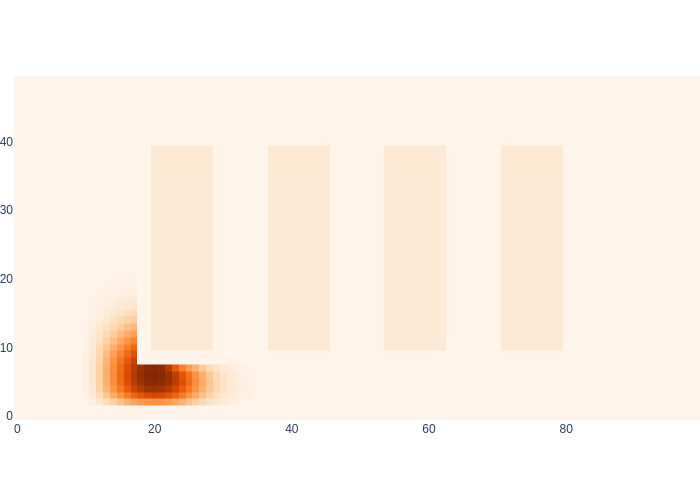
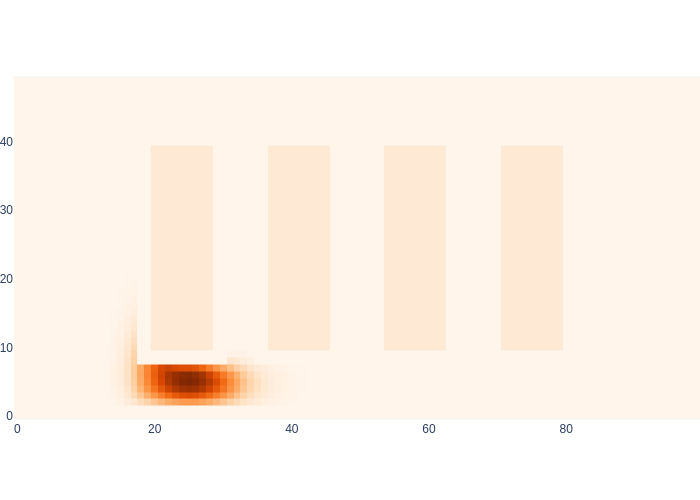
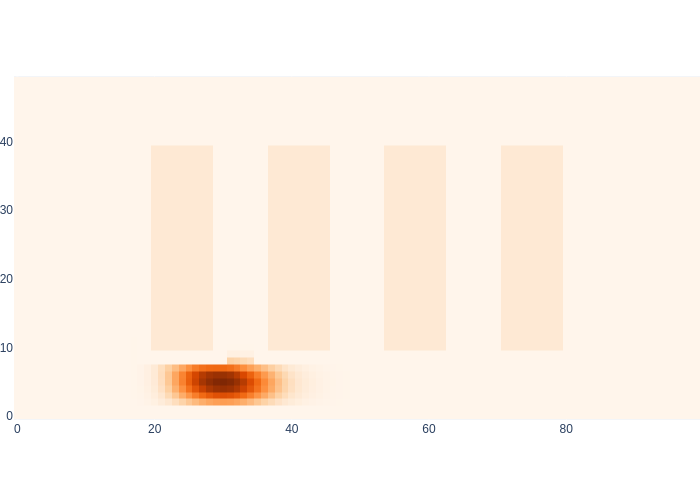
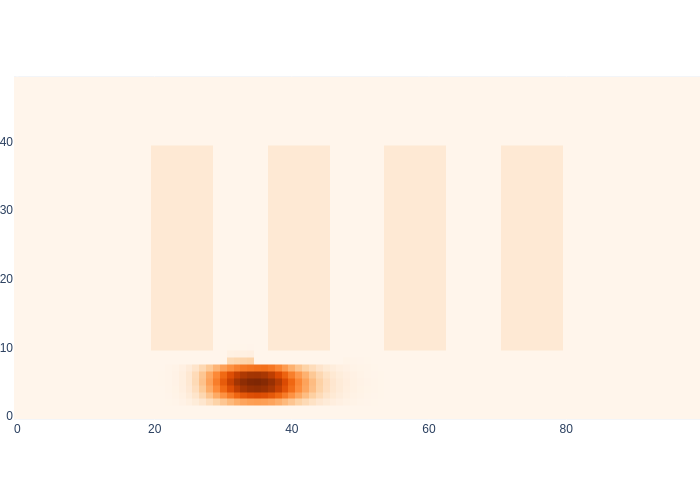
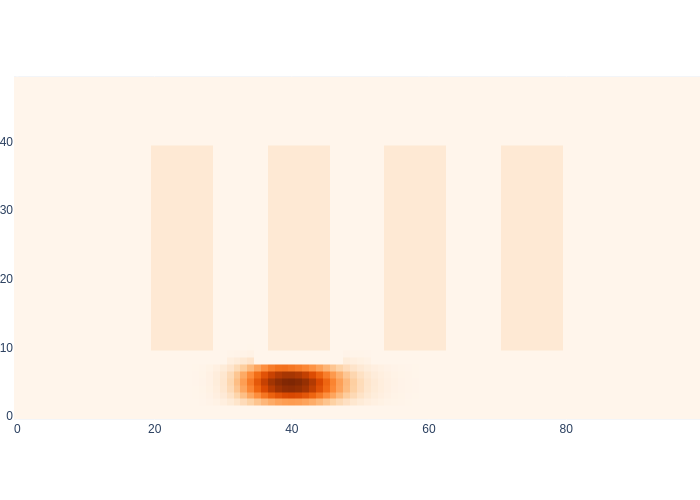
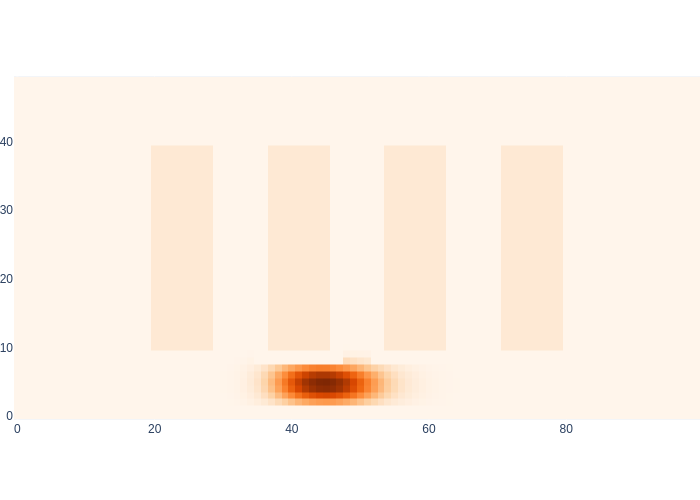
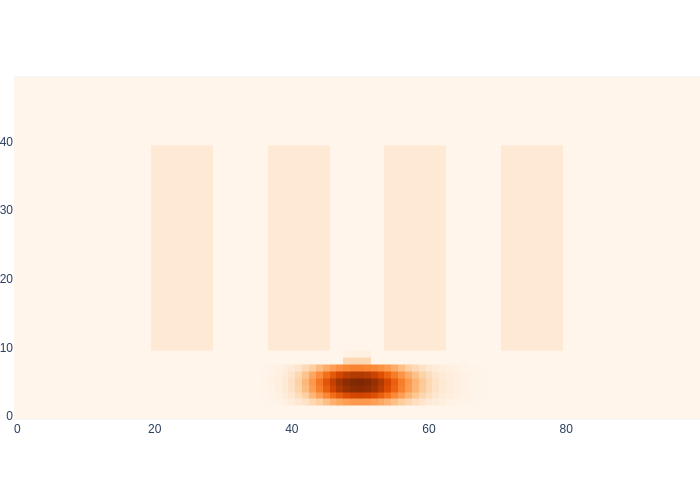
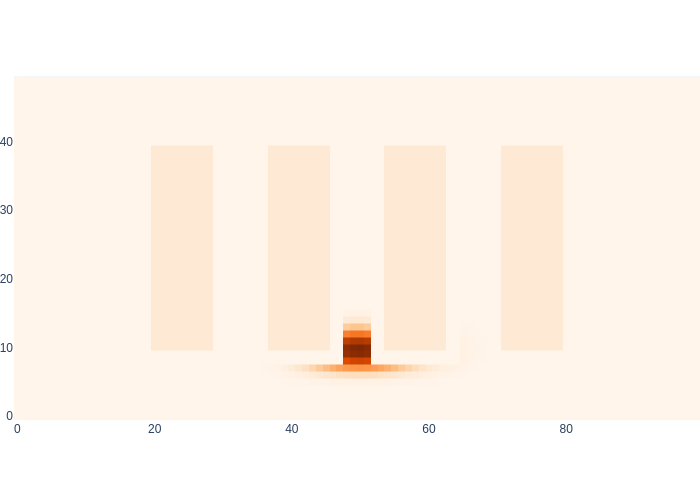
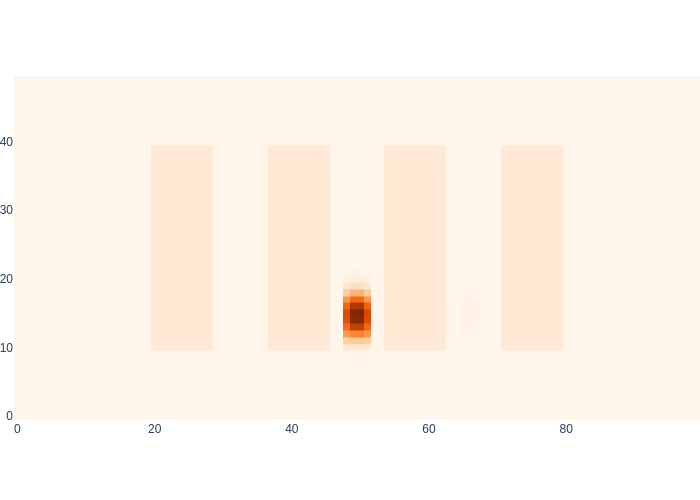
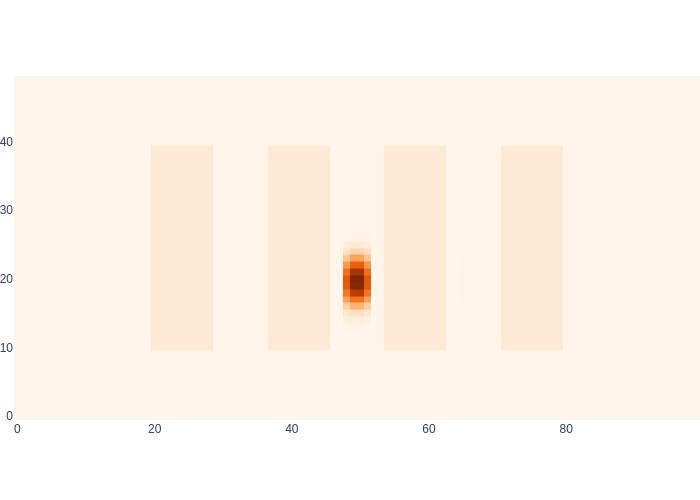
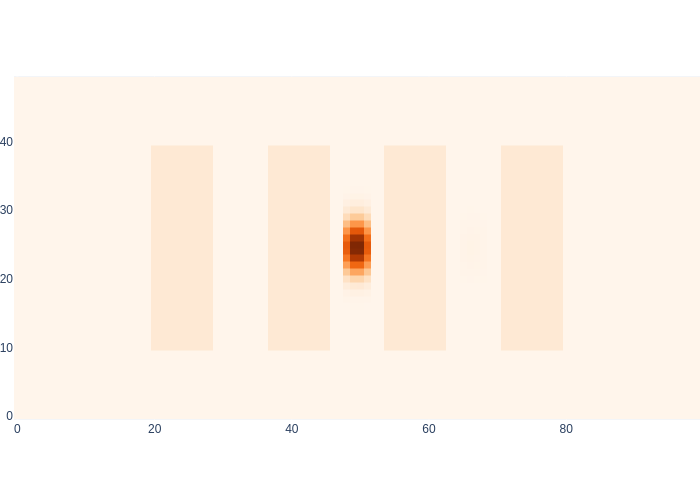
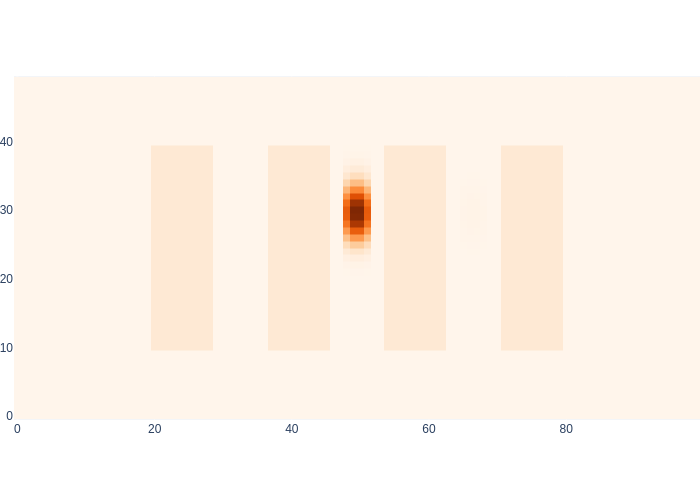

In [ ]:
"""
 If you have set show_map=True, run this cell to get the slide show 
 after running the previous cell. Otherwise, don't run this cell!
 
"""
if __name__ == '__main__':
  create_slide_show()

The following block is will show the estimated trajectory. Red - Estimated; Green - Ground Truth


In [ ]:
"""
  Display the estimated trajectory compared with the ground truth.
  Red is estimated, Green is ground truth
"""
if __name__ == '__main__':
  show_trajectory(gts, np.array(best_estimates))

# Part 2: Particle Filtering [(Section 4.4.2 in the Book)](https://www.roboticsbook.org/S44_logistics_perception.html#monte-carlo-localization)


Now, meet Jenny. Jenny uses Monte Carlo localization, or particle filtering. Particle filtering is similar to Markov localization, but different in the way it represents states: Markov localization represents state as a continuous space whereas Monte Carlo localization (particle filtering) represents state as samples collected from the space of states.


![](https://drive.google.com/uc?export=view&id=1CeyVF3witiRfLtdvIEAZVGNUjlY90xoe)


_Art: Meet Jenny_


Particle filtering first updates the samples of the motion model with likelihood weights from previous sensor observations. It does this by resampling the prior samples with prior weights and moving all the particles (samples) with the motion control instruction (motion update stage). Then, it calculates new likelihood weights based on current sensor observations for each particle (sensor update stage). The code below represents the process described.


Jenny uses 2 kinds of sensor readings to navigate her way around the warehouse:

1. Proximity sensor, which turns on when Jenny is very close to an obstacle.
2. RFID range sensor, which returns readings of type `(RFID_id, distance)` when Jenny is close to the RFID sensor. There are 8 fixed RFID sensors in the map at each end of the shelves. The distance measurement is assumed to have Gaussian noise. RFID_id is a unique id used to identify the sensor and the distance is the Gaussian Noise prone distance from the sensor.


In [ ]:
def likelihood_off(xy):
    """
        Calculate likelihood by looking up value in proximity_map_off. 
        Returns whether the proximity sensor is off.
    """
    #The following function calculates the correct cell for looking up the likelihood, and returns 0 likelihood if out of bounds
    j, i = np.round(xy).astype(int)
    if i < 0 or i > 49 or j < 0 or j > 99: return 0.0
    return float(logistics.proximity_map_off[i, j])


Jenny has an RFID range sensor which tells it the distance from a particular RFID sensor with some Gaussian Noise. We can use this RFID measurement(sensor_id, distance) and calculate the likelihood of being at a particular place(x,y) in the warehouse. The function below takes in the rfid_measurement and the xy coordinates as a tuple as arguments and returns the likelihood that a given point matches the reading of an RFID device.


In [ ]:
def likelihood_range(xy, rfid_measurement):
    """
        Calculate likelihood of xy given range measurement.
        Assumes Gaussian noise of the RFID range result.
        The function returns the likelihood that a given point matches the reading of an RFID device.
    """
    _id, _range = rfid_measurement
    if _id is None:
        j, i = np.round(xy).astype(int)
        if i < 0 or i > 49 or j < 0 or j > 99:
            return 0.0
        return float(logistics.out_of_bound_map[i, j])
    else:
        sigma = 1.0  # In meters
        range_for_xy = logistics.rfid_range(xy, logistics.beacons[_id])
        # Plug in the Gaussian noise
        return 0.0 if range_for_xy is None else np.exp(
            -1 / (2 * sigma**2) * (range_for_xy - _range)**2)


![](https://drive.google.com/uc?export=view&id=1dtJoZA1Qk24hcZaM8HLhJ8KYMi8lymgt)

_Art: Jenny uses RFID to sense range_


In [ ]:
def get_likelihood_off_weights(samples):
    """Calcuate the weight for each sample based on likelihood_off output"""
    weights = np.apply_along_axis(likelihood_off, 1, samples)
    return weights

The following function calculates the weight of each sample. It takes into account the likelihood_range output from the function that we defined previously

In [ ]:
def get_likelihood_range_weights(samples, position):
    """Calcuate the weight for each sample based on likelihood_range output """
    range_measurement = logistics.rfid_measurement(position)
    weights = np.apply_along_axis(likelihood_range, 1, samples,
                                  range_measurement)
    return weights

Below is the code that defines the motion update and the sensor update stages of particle filtering.


In [ ]:
def predict_samples(samples, weights, control, motion_model_sigma, size=500):
    """Create predictive density from weighted samples given control and control stddev. """
    prediction_samples = None
    weights /= np.sum(weights)
    # Resample
    component_indices = rng.choice(len(samples), size=size, p=weights)
    # Motion update
    means = samples + control
    # Inject Gaussian noise
    cov = np.eye(2) * motion_model_sigma**2
    prediction_samples = np.array(
        [rng.multivariate_normal(means[s], cov) for s in component_indices])
    return prediction_samples

Jenny uses the following code block to run particle filtering or Monte Carlo localization. This multiplies the two likelihoods in ever measurement update phase

In [ ]:
def run_particle_filter(samples,
                        indices,
                        weights,
                        sigma,
                        control_values,
                        size=500,
                        show_map=False):
    sample_sequence = []
    for k in indices[:-1]:
        # Ground truth control instruction
        control = control_values.at(x[k + 1]) - control_values.at(x[k])
        # Predict samples based on control
        samples = predict_samples(samples, weights, control, sigma, size)
        sample_sequence.append((samples, weights))

        # Calculate likelihood weights for next control update
        weights = get_likelihood_off_weights(samples) \
            * get_likelihood_range_weights(samples, control_values.at(x[k+1]))

        if show_map:
            logistics.show_map(0.1 * logistics.base_map,
                               markers=samples,
                               marker=dict(color="red",
                                           opacity=0.1,
                                           size=10 * weights /
                                           np.max(weights)),
                               file="{}.png".format(k))
            if k != indices[-2]:
                clear_output(wait=True)
    return sample_sequence

### CODING TODO 3

However, similar to the problem we ran into with Manuel, all we have is an array of possible Jennys. We are only concerned about estimating _one_ Jenny.

In the below cell implement a function to figure out Jenny's estimated location from the output samples. 
* Use the weighted average of the locations based on the samples. 
* Return a tuple of floats which is the weighted average of the sample coordinates

(Hint: use `np.average`). 


In [ ]:
#Coding TODO 3
def get_particle_filtering_best_estimate(samples, weights):
    """
      samples: List[(float, float)], list of sample coordinates
      weights: List[float], list of weight for each sample
      
      Returns:
        best_estimate: (float, float), the average of the sample coordinates with weights=weights
    """
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    best_estimate = np.average(samples, axis=0, weights=weights)
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
    return best_estimate

### CODING TODO 4
In the next cell: 

* Use euclidean distance to calculate the distance between the estimated locations and the ground truth locations. 
* The averaged distance will be used as the error metric for the estimated locations in the assignment.
* Low error value (shorter distance) means the estimation is good.

(Tip: use `np.linalg.norm`) You will need to call the function you implemented above.


In [ ]:
# Coding TODO 4
def get_particle_filtering_error(sample_sequence, ground_truth_values):
    """ 
        Loop over the ground truth values and calculate the average distances using euclidean distance.
        Save your estimates in the best_estimates array and return with the error.

        sample_sequence: List[(float, float)], list of tuples of samples and weights for each step
        ground_truth_values: List[(float, float)], list of ground truth locations for each step

        Returns:
          average_distance: float, average distance from the estimated locations to the ground truth
          best_estimates: List[(float, float)], list of location estimations along the trajectory for each 
            step with length equals to the ground_truth_values
    """
    n = len(ground_truth_values)
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    best_estimates = []
    distances = []
    for i in range(n):
      a = ground_truth_values[i]
      b = get_particle_filtering_best_estimate(sample_sequence[i][0], sample_sequence[i][1])
      dist = np.linalg.norm(a - b)
      best_estimates.append(b)
      distances.append(dist)
    average_distance = np.average(distances)
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
    # Return the average error
    return best_estimates, average_distance

**The next cell contains functions for initializing the samples. You will find them useful in a proceeding task.**


In [ ]:
# uniform
def get_uniform_distribution(num_samples):
    return rng.uniform(low=gtsam.Point2(0, 0),
                       high=gtsam.Point2(100, 50),
                       size=(num_samples, 2))


# node centered
def get_node_centered_distribution(num_samples):
    return rng.multivariate_normal(values.at(x[1]),
                                   np.diag([25, 25]),
                                   size=num_samples)


# multi-modal distribution
def get_multi_modal_distribution(num_samples):
    prior_samples = []
    points = [[10, 6], [80, 20], [45, 25], [20, 40]]
    for i in range(4):
        center = rng.multivariate_normal(points[i],
                                         np.diag([25, 25]),
                                         size=num_samples // 4)
        prior_samples.append(center)
    return np.concatenate(prior_samples, axis=0)


**Please alter the variable values in the cell below to complete the todos for this section.**


In [ ]:
if __name__ == '__main__':
  tic()

  motion_model_sigma_pf = 1.0 # Only alter for Report Q 3.1. Default is 1.0
  sample_size = 500 # Only alter for Report Q 3.3. Default is 500
  samples = get_uniform_distribution(sample_size) # Alter only for Report Q 3.6. Default is "get_uniform_distribution(sample_size)"

  # We could first calculate weights to filter out unlikely samples before we start
  weights = get_likelihood_off_weights(samples) \
              * get_likelihood_range_weights(samples, values.at(x[1]))
  sample_sequence = [(samples, weights)]
  ss = run_particle_filter(samples, indices, weights, motion_model_sigma_pf, values, sample_size, show_map=True)
  sample_sequence.extend(ss)

  gts = np.array([values.at(x[k]) for k in indices])
  pf_best_estimates, average_distance = get_particle_filtering_error(sample_sequence, gts)
  print("Average error: ", average_distance)

  print(f"\nWall time: {toc()} s")

Average error:  9.334208975948922

Wall time: 7.484916540000086 s


The following block is will create a slide show if the show_map was set to True in the previous block. 

**Comment this block before submitting to Gradescope.**


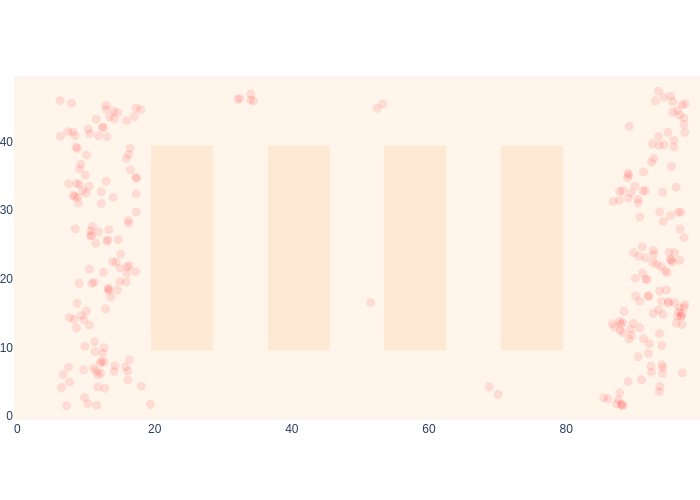
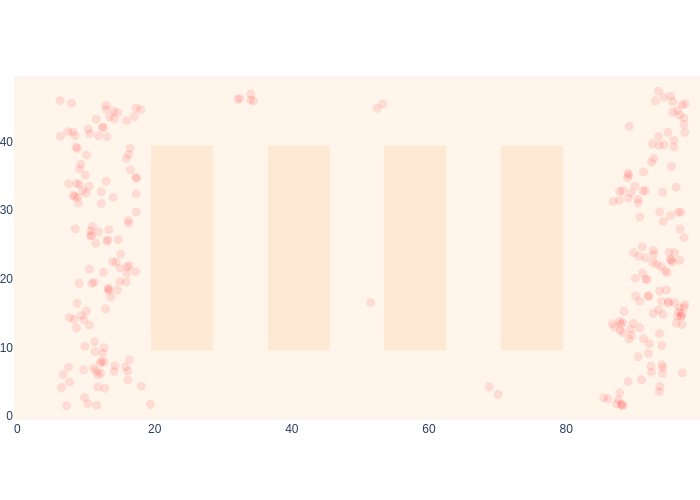
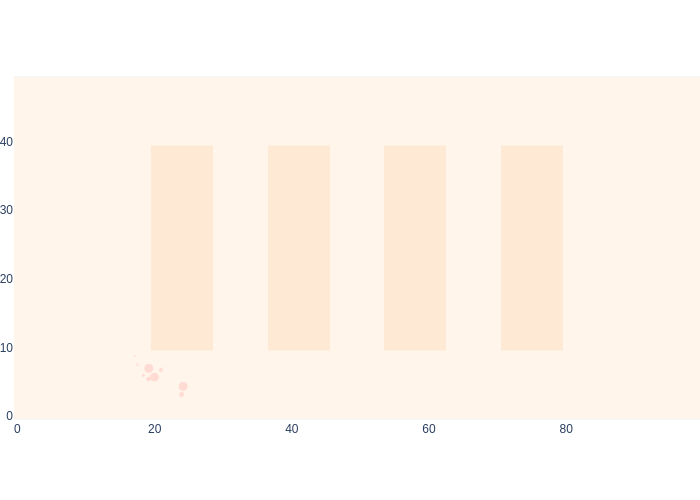
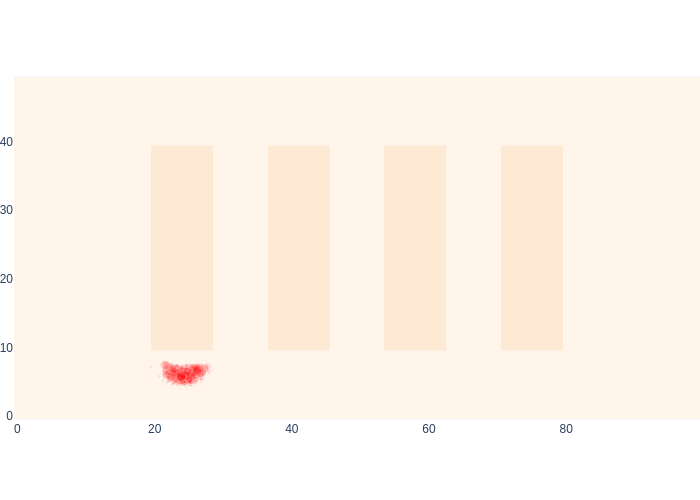
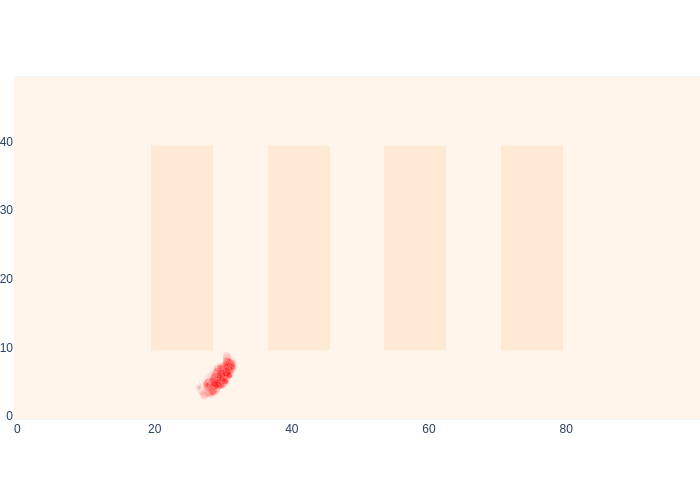
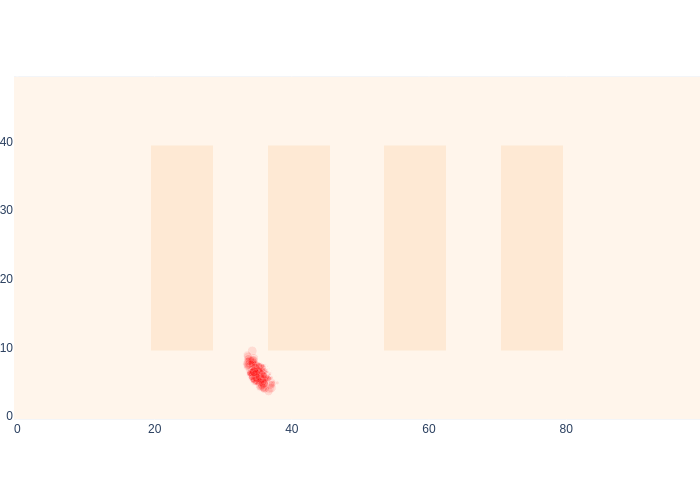
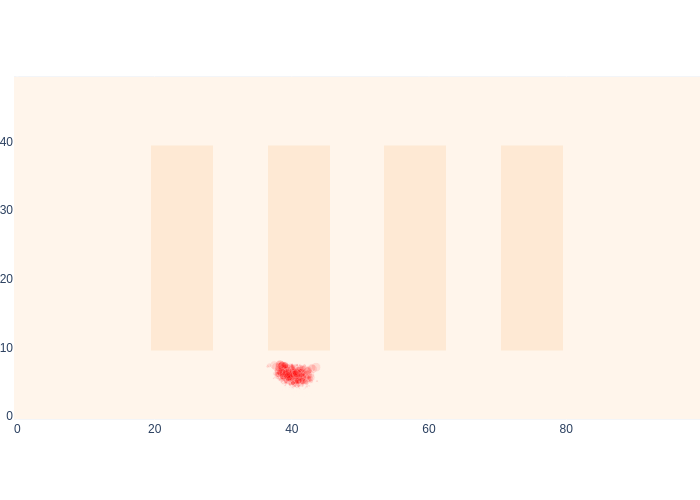
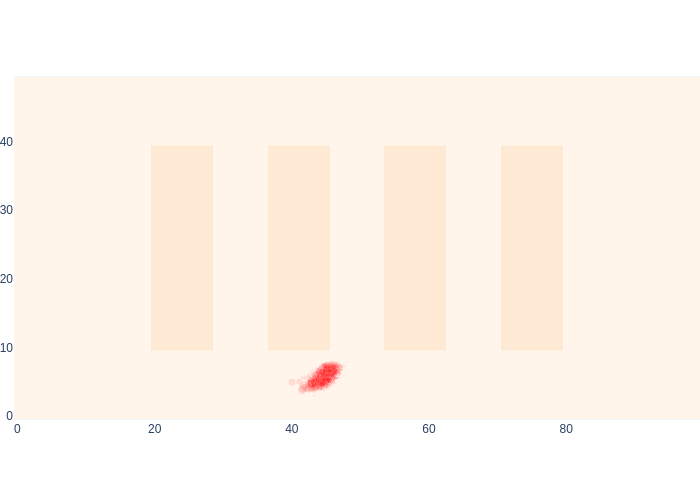
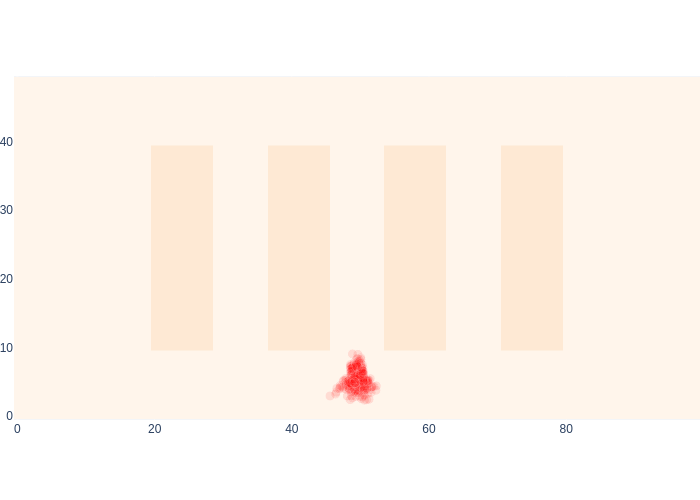
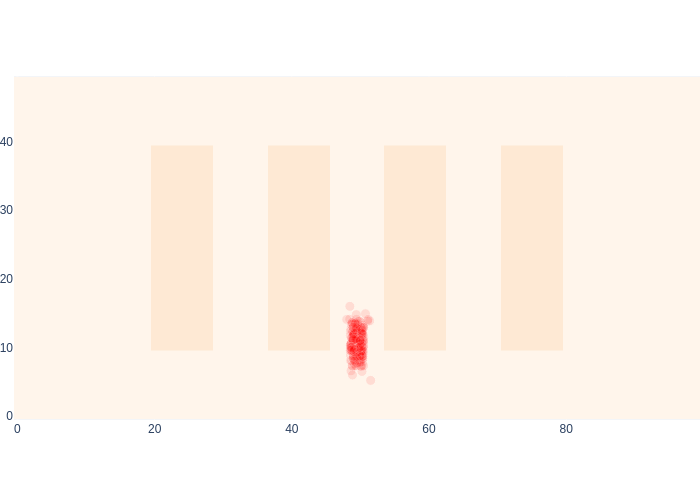
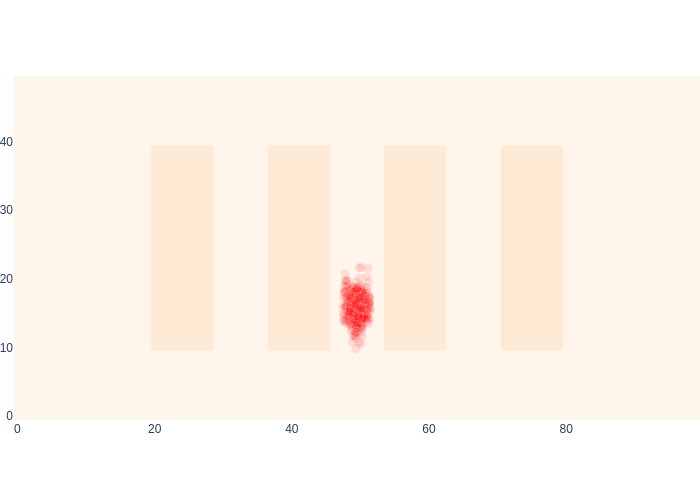
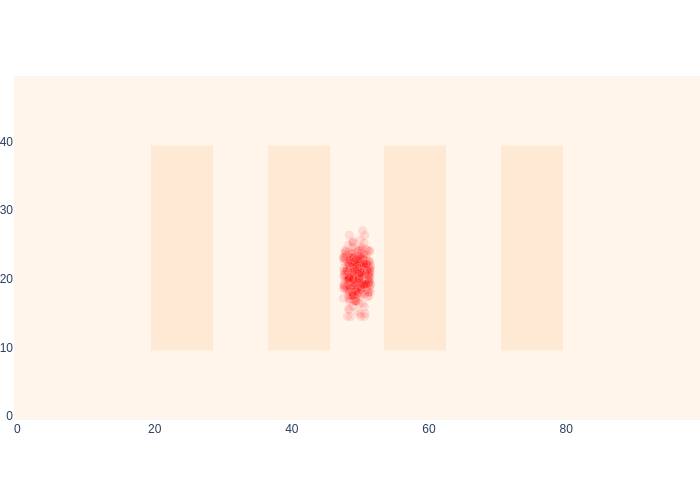
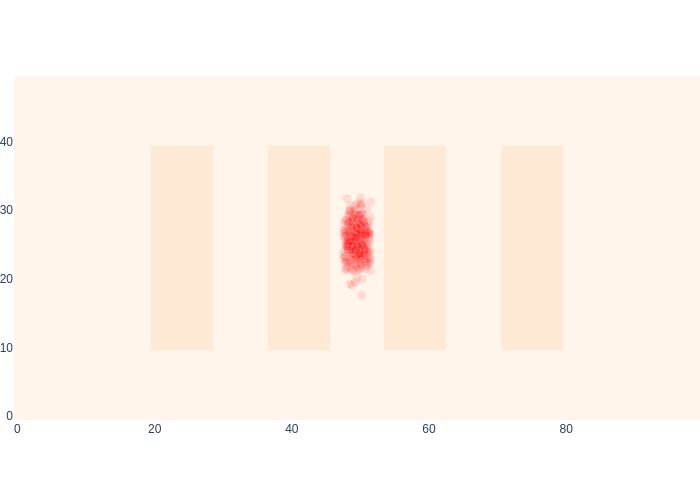
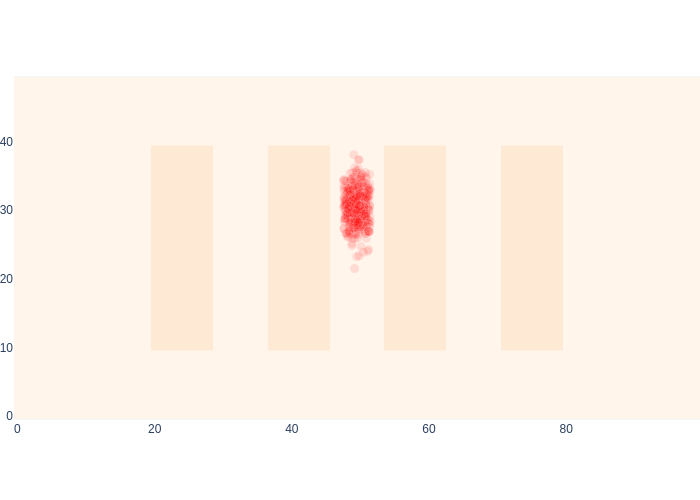

In [ ]:
"""
 If you have set show_map=True, run this cell to get the slide show 
 after running the previous cell. Otherwise, don't run this cell!
 
"""
if __name__ == '__main__':
  create_slide_show()

The following block is will show the estimated trajectory. Red - Estimated; Green - Ground Truth


In [ ]:
"""
  Display the estimated trajectory compared with ground truth.
  Red is estimated, Green is ground truth

"""
if __name__ == '__main__':
  show_trajectory(gts, np.array(pf_best_estimates))

![](https://drive.google.com/uc?export=view&id=1tOA9_3guARWJ-KITEKZiEV8dgOWXNt2m)

_Art: Jenny wonders - what is the best sample size?_


# Part 3: Compare the Two Algorithms


![](https://drive.google.com/uc?export=view&id=1iOQXekxIXghwtom7WvtM1jGk0GR-vIA-)

_Art: Calvin "Kalman" Hobbs makes a bet... \$v\$_


Calvin "Kalman" Hobbs has a bet with Tom "Trial-and-Error" Robinson that Jenny can move boxes faster than Manuel. The bet is worth 5 dollars. You can use the parameters from Part 1 and 2 to help Calvin and Tom decide who gets the 5 dollars with the magic of graphs! You will plot two graphs and upload screenshots onto the Project 3 Gradescope report. **No coding or parameter changing is needed for this part.**


**Your results in TODO 2.1 (the running time and average distance of Markov Localization with motion sigma=1.0) and TODO 3.3 (running time and average distances of Particle Filtering with different sample sizes) will be used in this part for plotting the graphs.**


![](https://drive.google.com/file/d/132IqnLklEuBjYfUNDxRbViOpOYCRyzeZ/view?usp=sharing)

_Art: Robot too tired to run experiments_


### TODO 3.1

Plot a graph with **sample size** on the x-axis and **running time** on the y-axis. We would like to compare the running time of particle filtering to that of Markov localization. Since the number of states in Markov localization in this assignment is always 5000 (equivalent to 5000 static samples), you should plot a horizontal line showing the running time of Markov localization with sigma of `1.0`. Then, plot the running time of particle filtering at each sample size. Connect each point with a line if possible. You can use any plotting tool.


The graph should look similar to the following graph. (The trends are more important than the exact values)
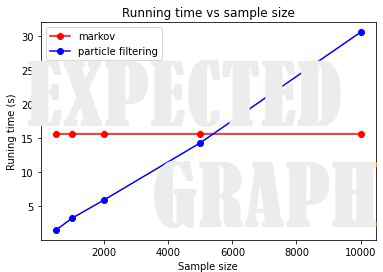




Particle Filtering is generally faster than Markov localization. But what about error? In the next TODO, you will compare the error of the two algorithms.

### TODO 3.2

Plot a graph with **sample size** on the x-axis and **error** (average distance) on the y-axis. Again, please plot a horizontal line showing the average distance of Markov localization with sigma of `1.0`. Then, plot the scatter points of the error (average distance) of particle filtering at each different sample size. Connect each point with a line if possible. You can use any plotting tool.


The graph should look similar to the following graph. (The trends are more important than the exact values)
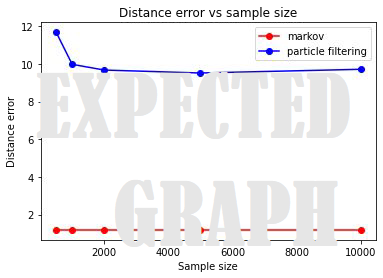




# Part 4: Path following using Particle Filtering


Assume that Jenny is randomly placed into a map and has no idea where she is. She has some knowledge about the map and can obtain sensor data and motion data. Per usual, she will use Monte Carlo localization to estimate her location with proper control. The initial estimated location will be the mean of the randomly initialized samples. As in the next TODO, you will find out that motion in the map along with Monte Carlo localization will help Jenny's estimated location converge to a point close to the ground truth.


![](https://drive.google.com/uc?export=view&id=1pBWAvoRAlXMRXc9MY2L5enq9PBPJkVFp)

_Art: Jenny figures out her location_


The `show_map_with_robot()` function below is an utility function for displaying the map of the warehouse and position of the robot in it using markers. 

In [ ]:
def show_map_with_robot(image=None,
                        markers=None,
                        robot=None,
                        display=False,
                        file: str = None,
                        marker={}):
    """ Utility function to show image on warehouse map, possibly with markers and robots """
    fig = px.imshow(image,
                    color_continuous_scale='Oranges',
                    origin="lower",
                    aspect='equal',
                    range_color=[0, 1])
    fig.add_scatter(x=[int(robot[0])],
                    y=[int(robot[1])],
                    mode="markers",
                    marker=dict(color="green", opacity=1, size=10))
    if markers is not None:
        fig.add_scatter(x=markers[:, 0],
                        y=markers[:, 1],
                        mode="markers",
                        marker=marker)

    fig.update_layout(coloraxis_showscale=False,
                      margin=dict(l=0, r=0, t=0, b=0))
    fig.update_xaxes(range=[-0.5, 99.5], autorange=False)
    fig.update_yaxes(range=[-0.5, 49.5], autorange=False, scaleratio=1)
    if display:
        fig.show()
    if file is not None:
        fig.write_image(file)

## Warehouse Navigator ([Book Section 4.4.2.3](https://www.roboticsbook.org/S44_logistics_perception.html#mcl-warehouse-example))


The robot navigates the warehouse with the help of the **WarehouseNavigator** class. It resets its ground truth to a different position or updates it as an offset from the current ground truth using controls in all four directions left, right, up, and down. The updated location of the robot is estimated with the `get_particle_filtering_best_estimate()` function that you already completed in Part 1. Given a start and target location, the robot follows a straight path within the warehouse in a particular direction using particle filtering. 



### CODING TODO 5,6

There are two coding TODOs you are required to complete as follows:
#### Coding TODO 5: 
* The robot should not go out of bounds and stop within 1.0 of the target. Determine the stopping criteria of the robot.

  **Hints:**
  - Use `likelihood_off()` to detect out of bounds. 
  - Use `np.linalg.norm` to calculate distance.
  
#### Coding TODO 6:  
* Determine the control of the robot in the specified direction towards the target while the stopping criteria does not satisfy.

For your convenience, the TAs have already completed a majority of this code in the following class definition:

In [ ]:
CONTROLS = {
    'UP': (0, 2),
    'DOWN': (0, -2),
    'LEFT': (-2, 0),
    'RIGHT': (2, 0)
    }

In [ ]:
class CrippledNavigator():
    """All the code that the TAs wrote to make your life easy for navigating a warehouse."""
    
    def __init__(self):
        self.ground_truth = np.array([0, 0]).astype(np.float64)
        self.motion_sigma = 1
        self.sample_size = 2000

    def reset_ground_truth(self, point):
        self.ground_truth = np.array(point).astype(np.float64)

    def update_ground_truth(self, control):
        self.ground_truth += np.array(control).astype(np.float64)

    def get_rfid_measurement(self):
        return logistics.rfid_measurement(self.ground_truth)

    def save_map(self, index, samples, weights):
        show_map_with_robot(0.1 * logistics.base_map,
                            markers=samples,
                            marker=dict(color="red",
                                        opacity=0.1,
                                        size=10 * weights / np.max(weights)),
                            robot=self.ground_truth,
                            display=False,
                            file="{}.png".format(index))

    def stopping_criteria(self, estimated_location, target):
        """You have to override this method in the derived class."""
        raise RuntimeError("You have to override 'stopping_criteria' in the derived class.")

    def update_estimate(self, samples, weights):
        """ Return the estimated location using the function you filled before. """
        return get_particle_filtering_best_estimate(samples, weights)

    def choose_control(self, estimated_location, target):
        """You have to override this method in the derived class."""
        raise RuntimeError("You have to override 'choose_control' in the derived class.")

    def follow_straight_path(self,
                             start,
                             target,
                             direction='LEFT',
                             prior_samples=None,
                             save_map=False):
        """
        Follows a straight path with given start and target in a specified direction. 
        Provide a prior_samples if you would like a pre-initialized sample distribution.

        Parameters:
          start (float, float): start location of the robot
          target (float, float): target location of the robot
          direction (str): specified direction
          prior_samples (List[(float, float)]): list of sample coordinates for pre-initalization 
          save_map (bool): indicator to save map 

        Returns:
          estimated_locations (List[(float, float)]): list of estimated_locations for each step
          gts (List[(float, float)]): list of ground truths for each step
          samples (List[(float, float)]): list of samples in the last step of the while loop
    """
        self.reset_ground_truth(start)
        init_rfid_measurement = self.get_rfid_measurement()
        samples = get_uniform_distribution(
            self.sample_size) if prior_samples is None else prior_samples
        if save_map:
            self.save_map(0, samples,
                          np.ones(self.sample_size) / self.sample_size)

        index = 0
        weights = get_likelihood_off_weights(samples) \
                * get_likelihood_range_weights(samples, start)

        estimated_location = self.update_estimate(samples, weights)
        estimated_locations = [estimated_location]
        gts = [self.ground_truth.copy()]

        while not self.stopping_criteria(estimated_location, target):
            control = self.choose_control(direction)
            self.update_ground_truth(control)
            samples = predict_samples(samples,
                                      weights,
                                      control,
                                      self.motion_sigma,
                                      size=self.sample_size)
            rfid_measurement = self.get_rfid_measurement()
            weights = get_likelihood_off_weights(
                samples) * get_likelihood_range_weights(
                    samples, self.ground_truth)

            estimated_location = self.update_estimate(samples, weights)
            estimated_locations.append(estimated_location)
            gts.append(self.ground_truth.copy())
            index += 1
            if save_map:
                self.save_map(index, samples, weights)
        return estimated_locations, gts, samples


In [ ]:
class WarehouseNavigator(CrippledNavigator):
    """With your code the WarehouseNavigator will work."""
    
    def stopping_criteria(self, estimated_location, target):
        """
        Determines the stopping criteria for the robot.

        Parameters:
          estimated_location (float, float): estimated location of the robot
          target (float, float): target location of the robot

        returns a boolean for whether or not the robot must stop
        """
        ###############################################################################
        #                             START OF YOUR CODE                              #
        ###############################################################################
        dist = np.linalg.norm(np.array(estimated_location) - np.array(target))
        if dist > 1.0 or likelihood_off(self.ground_truth) < 1.00:
          return False
        return True
        ###############################################################################
        #                              END OF YOUR CODE                               #
        ###############################################################################
        
    def choose_control(self, direction):
        """
        Determines the best control out of the four available.

        Parameter:
          direction (str): specified direction

        returns the control for the given direction (float, float)
        HINT: It is straightforward. Do not overthink
        """
        ###############################################################################
        #                             START OF YOUR CODE                              #
        ###############################################################################
        return CONTROLS.get(direction)
        ###############################################################################
        #                              END OF YOUR CODE                               #
        ###############################################################################

The following code block calculates the **average error** between the estimated locations of the robot along the straight path obtained from the **WarehouseNavigator** and the ground truths given start and target points.

In [ ]:
# Way points
if __name__ == '__main__':
  #DONT CHANGE START AND DESTINATION
  starting_point = [40, 7]
  destination = [60, 7]
  navigator = WarehouseNavigator()
  estimated_locations, line_gts, _ = navigator.follow_straight_path(starting_point,
                                                        destination,
                                                        'RIGHT',
                                                        save_map=True)
  average_distance = np.sum(
      [np.linalg.norm(estimated_location - gt)
      for estimated_location, gt in zip(estimated_locations, line_gts)]) / len(line_gts)
  print("Average error: ", average_distance)

Average error:  0.9911017060983724



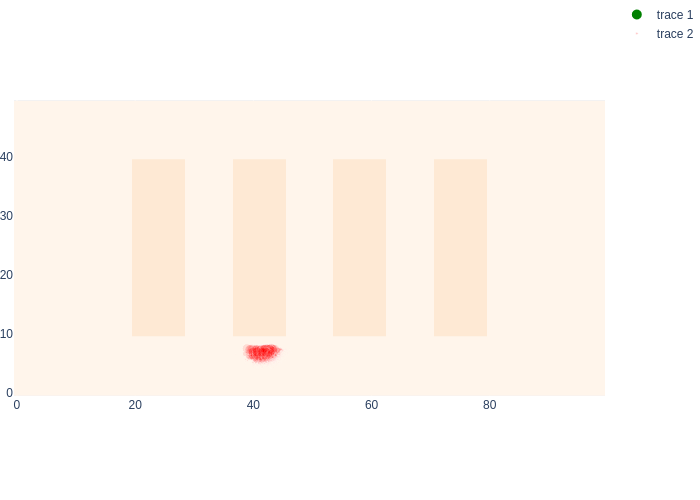
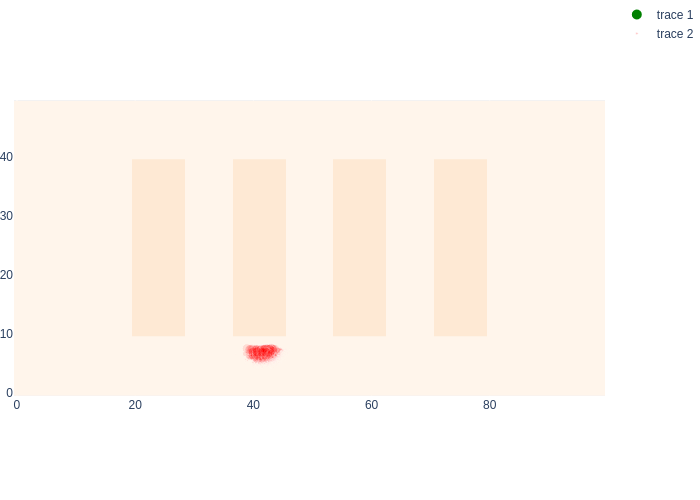
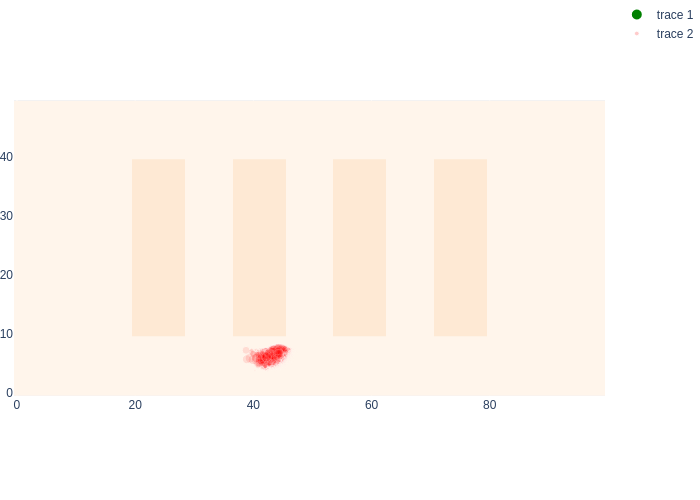
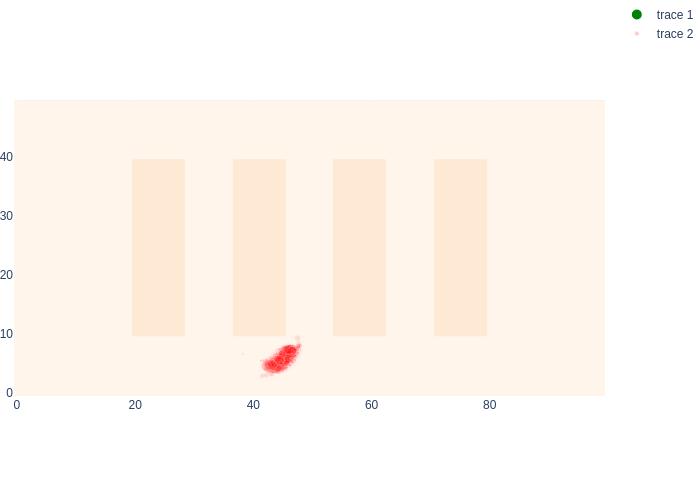
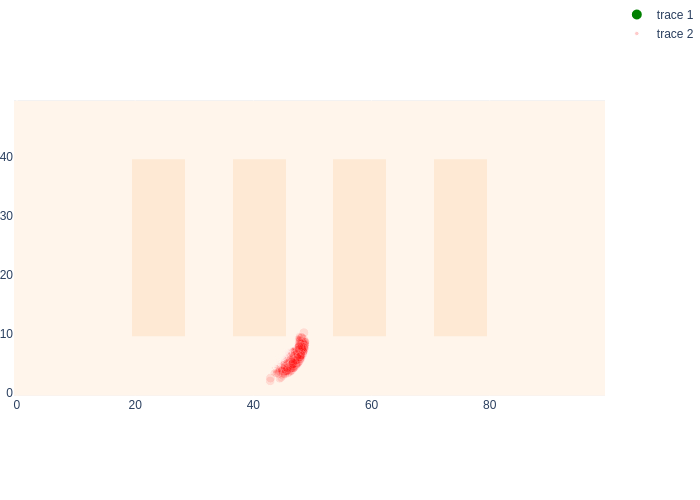
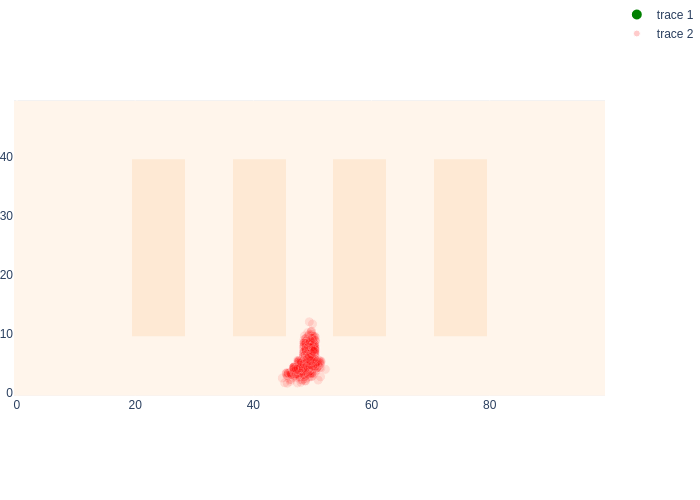
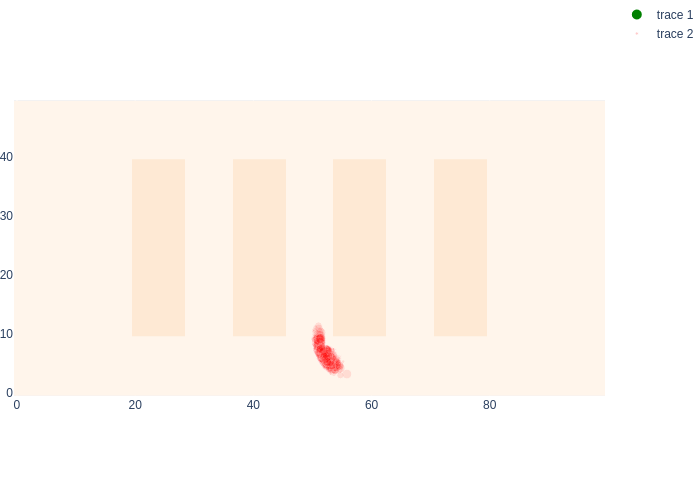
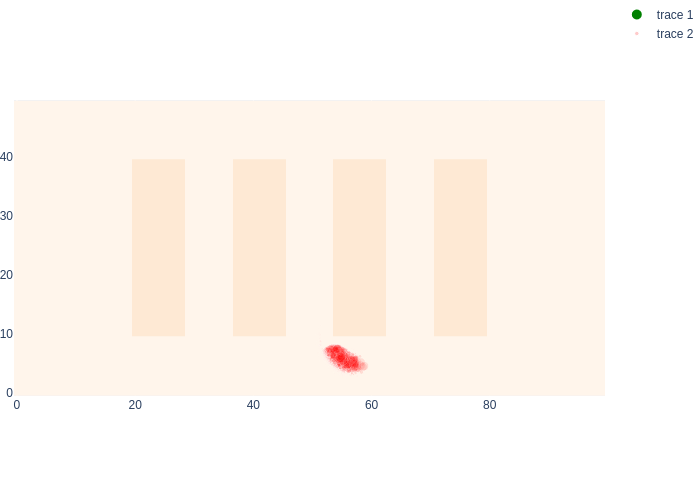
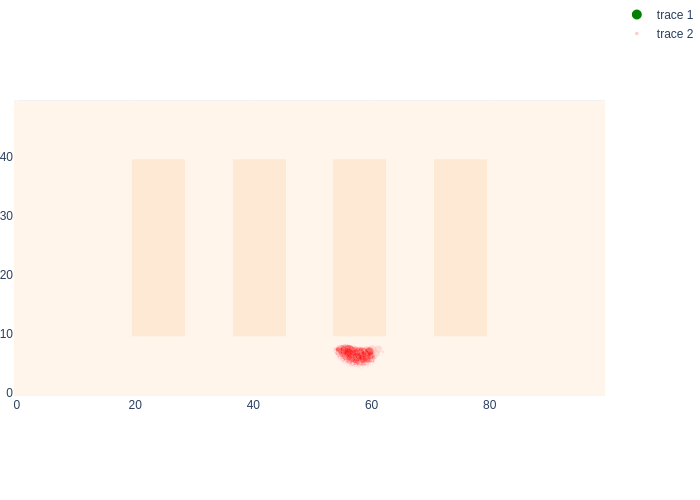
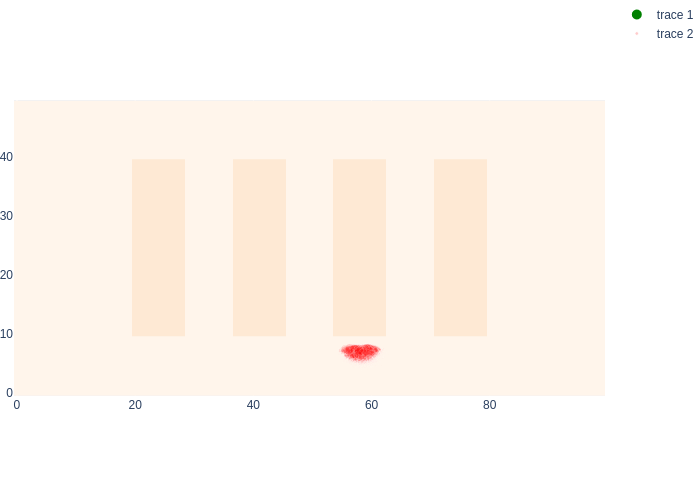
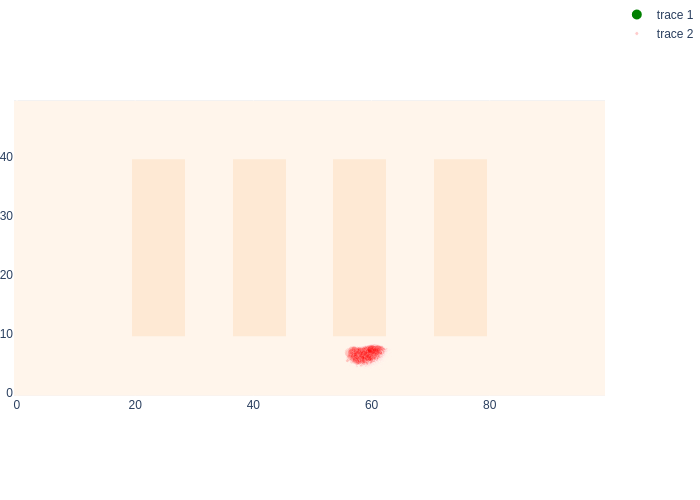

In [ ]:
"""
 If you have set show_map=True, run this cell to get the slide show 
 after running the previous cell. Otherwise, don't run this cell!
 
"""
if __name__ == '__main__':
  create_slide_show()

The following block is will show the estimated trajectory. Red - Estimated; Green - Ground Truth


In [ ]:
"""
  Display the estimated trajectory compared with ground truth.
  Red is estimated, Green is ground truth
"""
if __name__ == '__main__':
  show_trajectory(np.array(line_gts), np.array(estimated_locations))

If your implementation is correct, you should see the red sample points converge to the point of the robot (black dot in the map) after a few steps in the slide show. Sometimes, if the initialization is good enough, you'll find the estimated location close to the ground truth after the first step. The estimated trajectory (red dots) would be close to the ground truth (green dots).


### TODO 4.1

Insert a screenshot of the trajectory in the Gradescope report and report the error (average distance).


## 4.2 A More Complicated Path

Based on the previous example, you will create an advanced warehouse navigator to follow a path with multiple waypoints! Notice that the path could be decomposed into multiple `follow_straight_path()`executions to reach the final destination, since between each pair of waypoints lies a straight path. You will implement the function `follow_path_with_waypoints()` and observe the final distance to the destination. If your implementation for `follow_straight_path()` is correct, the robot should stop close to the waypoints, and the distance to every waypoint when stopping is within `1.0` based on stopping criteria in the `stopping_criteria()` function.


In [ ]:
# Waypoints
waypoints = [[30, 44], [50, 44], [50, 6], [66, 6], [66, 44], [80, 44]]

#### CODING TODO 7

Complete the last coding TODO of the project!

Use `follow_straight_path()` to complete this function. 
* You could assume that the robot's ground truth location is at the first waypoint. 
* The robot will always move in the 4 directions defined in the class, and the waypoints will always be in the 4 directions related to each other. 
* Start by iterating through the waypoints. 
* You could use any function defined in this class and its super-class.

**Remember:**
- Set save_map=False when running `follow_straight_path()`.
- When calling self.get_direction, use the given way points.
- Update all the variables(est_pts, traj_gts, prev_waypoint, prev_sample) after each loop of `follow_straight_path()`.
- Use the list `extend()` method.
- The navigation could run for a while. 

In [ ]:
class AdvancedWarehouseNavigator(WarehouseNavigator):

    def __init__(self):
        super().__init__()

    def get_direction(self, start, end):
        """ Return the estimated direction of the straight path as a string. """
        if start[0] == end[0]:
            if start[1] > end[1]:
                return 'DOWN'
            elif start[1] < end[1]:
                return 'UP'
        else:
            if start[0] > end[0]:
                return 'LEFT'
            elif start[0] < end[0]:
                return 'RIGHT'

    def follow_path_with_waypoints(self, waypoints):
        """
        Follows a path with multiple waypoints where a straight path exists between each pair of them.

        Parameters:
          waypoints List[(float, float)]: a list of waypoints

        Returns: 
          est_pts List[(float, float)]: a list of your estimated position along the trajectory
          gts List[(float, float)]: a list of ground truths along the trajectory
        """
        est_pts = []  # Estimated locations along the full trajectory
        traj_gts = []  # Ground truth lcoations along the full trajectory
        prev_waypoint = waypoints[0]  # Useful for calculating direction
        prev_sample = None  # Set prior_samples=prev_sample when calling follow_straight_path
        ###############################################################################
        #                             START OF YOUR CODE                              #
        ###############################################################################
        for target in waypoints[1:-1]:
          direction = self.get_direction(prev_waypoint, target)
          estimations, gts, prev_sample = self.follow_straight_path(prev_waypoint, target, direction, prev_sample)
          est_pts.append(estimations)
          traj_gts.append(gts)
          prev_waypoint = target
        ###############################################################################
        #                              END OF YOUR CODE                               #
        ###############################################################################
        return est_pts, traj_gts


The following code block calculates the **average error** between the estimated locations of the robot along the path obtained from the **AdvancedWarehouseNavigator** and the ground truths given multiple waypoints.

In [ ]:
if __name__ == '__main__':
  adv_navigator = AdvancedWarehouseNavigator()
  est_pts, traj_gts = adv_navigator.follow_path_with_waypoints(waypoints)
  average_distance = np.sum(
      [np.linalg.norm(estimated_location - gt)
      for estimated_location, gt in zip(estimated_locations, traj_gts)]) / len(traj_gts)
  print("Average distance: ", average_distance)

The following block is will show the estimated trajectory. Red - Estimated; Green - Ground Truth


In [ ]:
"""
  Display the estimated trajectory compared with ground truth.
  Red is estimated, Green is ground truth
"""
if __name__ == '__main__':
  show_trajectory(np.array(traj_gts), np.array(est_pts))

If your implementation is correct, you must see the estimated locations (red dots) and ground truths (green dots) close to each other ie. both the trajectories must follow the same path. 

### TODO 4.2

Insert a screenshot of the trajectory into the report on Gradescope and report the error (average distance).


## DONE WITH THIS PROJECT!! 